In [1]:
# Import necessary libraries

!pip install yfinance --upgrade --no-cache-dir
import sys
sys.path.append("/home/jovyan/.local/lib/python3.10/site-packages")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import wandb

# Set the style for visualizations
sns.set(style="darkgrid")


# Enable inline plotting for matplotlib
##
%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Environment setup complete!")

  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.61
    Uninstalling yfinance-0.2.61:
      Successfully uninstalled yfinance-0.2.61
Environment setup complete!


import site
site.getusersitepackages()
- **state[0]: return**

(price today-price yesterday)/price yesteday
  
- actions: buy, sell hold

In [2]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
print(f"Current CUDA device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

CUDA available: True
CUDA device count: 1
Current CUDA device: 0
Device name: Quadro T1000 with Max-Q Design


[*********************100%***********************]  1 of 1 completed


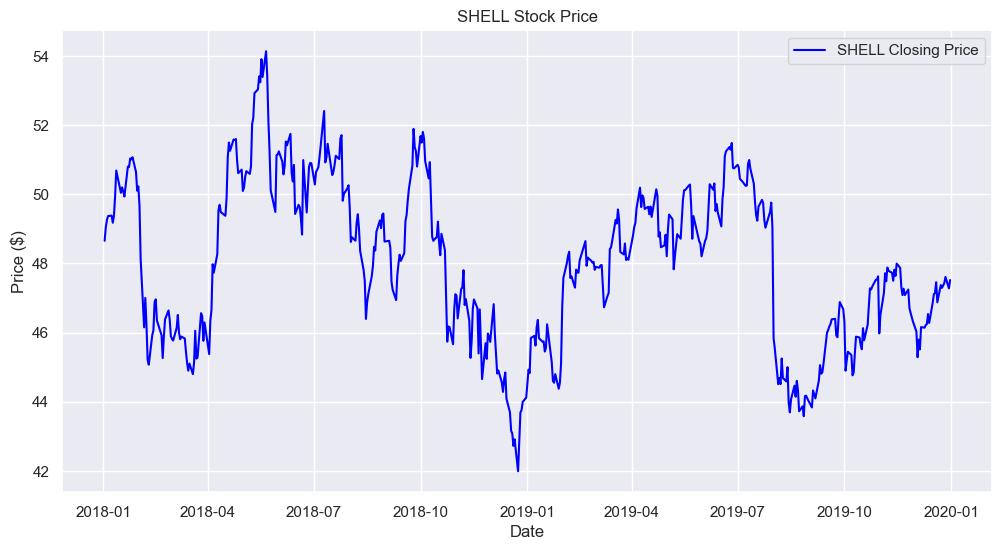

In [3]:
# Get stock data
data = yf.download("SHEL", start="2018-01-01", end="2020-01-01")

# Plot closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='SHELL Closing Price', color='blue')
plt.title('SHELL Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Train-test split


For time series data (especially financial data), you should split first, then transform - but with important considerations:

## Correct Order of Operations
1. First split your raw data into train/test sets

2. Then transform/scale each set separately using only **training** statistics

3. Never let test data influence your transformations

## Why This Matters
1. Prevents data leakage (test set information contaminating training)

2. Simulates real-world conditions where future data is unavailable

3. Maintains the temporal order of financial data

In [4]:
# 1. First split data chronologically

split_idx = int(len(data) * 0.8)
train_raw = data.iloc[:split_idx]
test_raw = data.iloc[split_idx:]



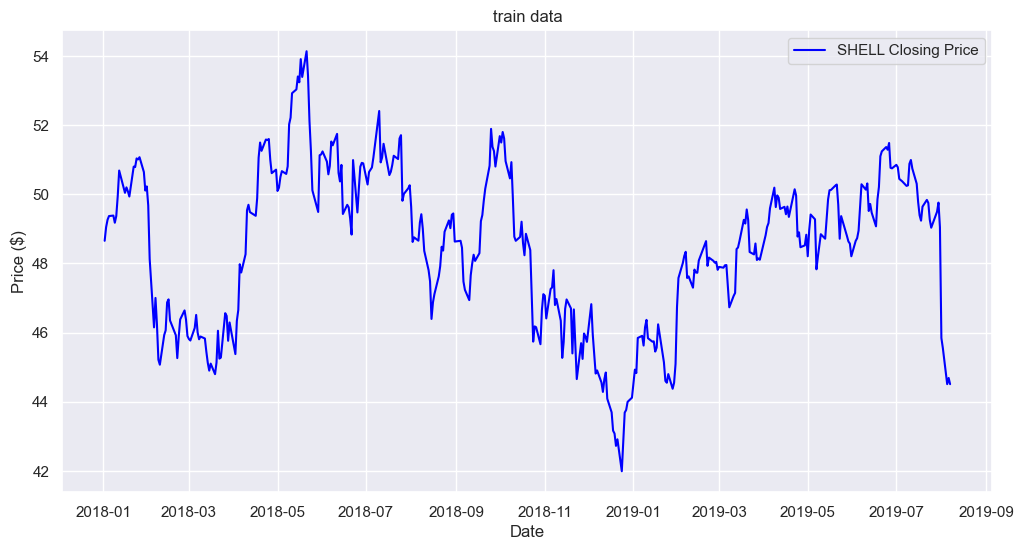

In [5]:
# Plot closing prices
plt.figure(figsize=(12, 6))
plt.plot(train_raw['Close'], label='SHELL Closing Price', color='blue')
plt.title('train data')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

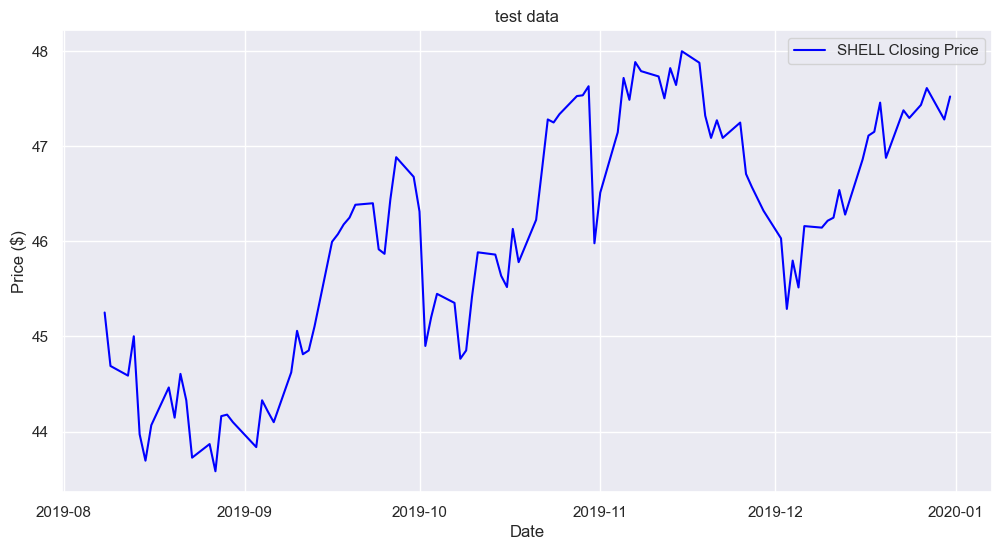

In [6]:
# Plot closing prices
plt.figure(figsize=(12, 6))
plt.plot(test_raw['Close'], label='SHELL Closing Price', color='blue')
plt.title('test data')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
print("Raw volume stats:")
print(train_raw['Volume'].describe())

Raw volume stats:
Ticker          SHEL
count   4.020000e+02
mean    3.240668e+06
std     1.218971e+06
min     1.032558e+06
25%     2.363634e+06
50%     2.991679e+06
75%     3.839714e+06
max     9.096246e+06


## Some features

### 1. Pct return

In [8]:
train_raw['pct_return'] = train_raw['Close'].pct_change()
train_raw=train_raw.fillna(0)

test_raw['pct_return'] = test_raw['Close'].pct_change()
test_raw=test_raw.fillna(0)


### 2. Volume Normalized

Volumes refers to the total number of shares that have been bought and sold during Time T, its a measure of how acively the stock is traded. Because the Volume can be easily in the thousands of millions depending on the stock the Volume should be normalized for the Neural Network, therefor we use a Log transformation Log(1 + Volume)

In [9]:
# Apply log
train_raw['Volume_log'] = np.log1p(train_raw['Volume'])
test_raw['Volume_log'] = np.log1p(test_raw['Volume'])

# Apply z-score normalization after log
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_raw['Volume_norm'] = scaler.fit_transform(train_raw[['Volume_log']])
test_raw['Volume_norm'] = scaler.transform(test_raw[['Volume_log']])

### 3. Moving Average normalized

In [10]:
prices_train = train_raw['Close'].values
prices_test = test_raw['Close'].values
ma_window=10

MA_train = np.array([np.mean(prices_train[max(0,t-ma_window):t+1]) for t in range(len(prices_train))])
MA_train = MA_train.reshape(-1,1)

train_raw['MA_norm'] = (MA_train - prices_train) / prices_train


MA_test = np.array([np.mean(prices_test[max(0,t-ma_window):t+1]) for t in range(len(prices_test))])
MA_test = MA_test.reshape(-1,1)

test_raw['MA_norm'] = (MA_test - prices_test) / prices_test



### 4. Diff from mean standardized

In [11]:
window=10


mean_train = train_raw['Close'].rolling(window=window).mean()
std_train = train_raw['Close'].rolling(window=window).std()
z_score_train = (prices_train - mean_train) / std_train
z_score_train = z_score_train.fillna(0)

train_raw['diff_mean_standardized'] = z_score_train



mean_test = test_raw['Close'].rolling(window=window).mean()
std_test = test_raw['Close'].rolling(window=window).std()
z_score_test = (prices_test - mean_test) / std_test
z_score_test = z_score_test.fillna(0)

test_raw['diff_mean_standardized'] = z_score_test



### 5. Relative Strength Index

The relative Strenght Index (RSI) is a momentum indicator used in technical analysis, it measuers the speed and the magnitude of a securtity's recent price change.
it is displayed as an oscialter on a scale of [0 - 100]. This indicator compares a security's strength on days when prices go up to its strength on days when prices go downn. 

RSI = 100 - [100/(1+(Average gain)/Average loss)]

RSI > 70, Typically the asset is overbought
RSI < 30, Typically the asset is oversold

In [12]:

window = 14  # RSI window

# Train set
delta_train = train_raw['Close'].diff().fillna(0)
gain_train = delta_train.where(delta_train > 0, 0)
loss_train = -delta_train.where(delta_train < 0, 0)
avg_gain_train = gain_train.rolling(window=window).mean()
avg_loss_train = loss_train.rolling(window=window).mean()
RS_train = avg_gain_train / (avg_loss_train + 1e-10)
RSI_train = 100 - (100 / (1 + RS_train))
RSI_train = RSI_train.fillna(50)

# Normalize RSI to 0-1 range:
train_raw['RSI_norm'] = RSI_train / 100.0


# Test set
delta_test = test_raw['Close'].diff().fillna(0)
gain_test = delta_test.where(delta_test > 0, 0)
loss_test = -delta_test.where(delta_test < 0, 0)
avg_gain_test = gain_test.rolling(window=window).mean()
avg_loss_test = loss_test.rolling(window=window).mean()
RS_test = avg_gain_test / (avg_loss_test + 1e-10)
RSI_test = 100 - (100 / (1 + RS_test))
RSI_test = RSI_test.fillna(50)

# Normalize RSI to 0-1 range:
test_raw['RSI_norm'] = RSI_test / 100.0



In [13]:
test_raw

Price,Close,High,Low,Open,Volume,pct_return,Volume_log,Volume_norm,MA_norm,diff_mean_standardized,RSI_norm
Ticker,SHEL,SHEL,SHEL,SHEL,SHEL,,,,,,
Date,,,,,,,,,,,
2019-08-08,45.251762,45.275159,44.549821,44.791601,3171885,0.000000,14.969837,0.121187,0.000000,0.000000,0.500000
2019-08-09,44.690205,45.016999,44.557617,44.783796,3782192,-0.012410,15.145815,0.614812,0.006283,0.000000,0.500000
2019-08-12,44.588802,44.955372,44.565405,44.838384,2456260,-0.002269,14.714151,-0.596025,0.005714,0.000000,0.500000
2019-08-13,45.002186,45.345356,44.370438,44.464030,2823832,0.009271,14.853606,-0.204847,-0.002643,0.000000,0.500000
2019-08-14,43.972672,44.176233,43.746490,44.019466,3671340,-0.022877,15.116068,0.531371,0.016566,0.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,47.295765,47.432736,47.223250,47.223250,1128056,-0.001701,13.936007,-2.778754,-0.009308,0.856181,0.690573
2019-12-26,47.432735,47.593880,47.408565,47.416621,1229020,0.002896,14.021728,-2.538302,-0.009837,0.997119,0.753192


## Action Space

In [14]:
actions = {0: 'Buy', 1: 'Sell', 2: 'Hold'}

In [15]:
#takes action and updates cash and holdings accordingly

def state_transition_with_action(price, portfolio_state, action):
    
    cash= portfolio_state['cash']
    holdings= portfolio_state['holdings']

    # 2. Apply action (with validation)
    trade_size = 0.1  # 10% of cash/holdings
    new_cash, new_holdings = cash, holdings  # Default: hold
    
    if action == 0:  # Buy
        if cash > 0:  # Only buy if cash available
            max_affordable = cash / price
            buy_amount = min(trade_size * max_affordable, max_affordable)
            cost = buy_amount * price
            new_holdings = holdings + buy_amount
            new_cash = cash - cost
        else:
            action = 2  # Fallback to hold if no cash
    
    elif action == 1:  # Sell
        if holdings > 0:  # Only sell if holdings available
            sell_amount = trade_size * holdings
            new_cash = cash + (sell_amount * price)
            new_holdings = holdings - sell_amount
        else:
            action = 2  # Fallback to hold if no holdings

    
    return new_cash, new_holdings

## Reward functions


In reinforcement learning-based trading, the reward function is critical. It defines the objective the agent is optimizing—whether it's maximizing profit, minimizing risk, or outperforming a benchmark. Different reward functions offer different perspectives on what constitutes a “good” trading decision.

Below are the reward functions that we use for our trading algorithm. 

### 1. `reward_function_gain`

**Description:**  
Measures the simple return (percentage gain or loss) in portfolio value over one step.

**Formula:**  
`reward = ((new_value - old_value) / old_value) * 1000`

**Why it’s scaled:**  
Raw returns are often small (e.g., 0.001 = 0.1%). Scaling by `1000` improves signal strength during training and prevents gradient vanishing.

### 2. `reward_log_with_fees`

**Description:**  
Uses log returns, which are time-consistent and symmetric, and subtracts transaction costs when the agent buys or sells.

**Formula:**  
`reward = (log(new_value / old_value) - transaction_cost) * 1000`

**Why it’s scaled:**  
Log returns are smaller in magnitude than simple returns. Scaling by `1000` ensures the reward remains numerically significant for learning.

### 3. `reward_sharpe`

**Description:**  
Approximates the Sharpe Ratio by dividing recent return by volatility. Encourages stable, risk-adjusted growth.

**Formula:**  
`reward = raw_return / std(recent_returns)`

**Why it’s *not* scaled:**  
The Sharpe ratio is already normalized. Scaling could distort its balance between return and risk.

### 4. `reward_vs_benchmark`

**Description:**  
Rewards the agent for outperforming a benchmark return (e.g., passive holding of the asset).

**Formula:**  
`reward = (agent_return - benchmark_return) * 1000`

**Why it’s scaled:**  
The return difference between the agent and the benchmark is often subtle. Scaling enhances this signal to make it more learnable.

### 5. `reward_drawdown_penalty`

**Description:**  
Penalizes drawdowns (declines from the highest portfolio value seen so far) while still rewarding gains.

**Formula:**  
`reward = raw_return - 0.001 * drawdown`

**Why it’s *not* scaled:**  
The penalty term is already internally scaled (`0.001 * drawdown`) to match the magnitude of typical returns. Extra scaling could overly punish the agent or destabilize training.



In [17]:
def reward_function_gain(price, old_portfolio, new_portfolio):
    """Reward based on raw portfolio value gain."""
    old_value = old_portfolio['cash'] + old_portfolio['holdings'] * price
    new_value = new_portfolio['cash'] + new_portfolio['holdings'] * price
    raw_return = (new_value - old_value) / old_value
    return raw_return * 1000


def log_reward_fees(price, old_portfolio, new_portfolio, action_t, transaction_cost_rate=0.001):
    """Reward based on log return, penalized by transaction fees for buy/sell actions."""
    old_value = old_portfolio['cash'] + old_portfolio['holdings'] * price
    new_value = new_portfolio['cash'] + new_portfolio['holdings'] * price
    log_return = np.log(new_value / old_value)

    # Apply cost only on buy or sell
    if action_t in [0, 1]:  # 0 = sell, 1 = buy
        transaction_cost = 0.1 * old_portfolio['cash'] * transaction_cost_rate
    else:
        transaction_cost = 0.0

    reward = (log_return - transaction_cost) * 1000
    return reward


def reward_sharpe(price, old_portfolio, new_portfolio, recent_returns, window=10):
    """Reward based on risk-adjusted return (Sharpe Ratio approximation)."""
    old_value = old_portfolio['cash'] + old_portfolio['holdings'] * price
    new_value = new_portfolio['cash'] + new_portfolio['holdings'] * price
    raw_return = (new_value - old_value) / old_value

    recent_returns.append(raw_return)
    if len(recent_returns) > window:
        recent_returns.pop(0)

    volatility = np.std(recent_returns) + 1e-6
    return raw_return / volatility


def reward_vs_benchmark(price, old_portfolio, new_portfolio, prev_price):
    """Reward for outperforming the market benchmark (price return)."""
    benchmark_return = (price - prev_price) / prev_price

    old_value = old_portfolio['cash'] + old_portfolio['holdings'] * price
    new_value = new_portfolio['cash'] + new_portfolio['holdings'] * price
    agent_return = (new_value - old_value) / old_value

    return (agent_return - benchmark_return) * 1000


def reward_drawdown_penalty(price, old_portfolio, new_portfolio, running_max):
    """Reward with penalty for drawdowns from peak portfolio value."""
    old_value = old_portfolio['cash'] + old_portfolio['holdings'] * price
    new_value = new_portfolio['cash'] + new_portfolio['holdings'] * price
    drawdown = max(0, running_max - new_value)

    raw_return = (new_value - old_value) / old_value
    penalty = 0.001 * drawdown

    return raw_return - penalty


### Reward selector

This function selects and computes the appropriate reward based on a chosen method:

#### `get_reward(...)` 

#### Parameters:
- `method`: One of `"raw"`, `"log"`, `"sharpe"`, `"benchmark"`, or `"drawdown"`.
- `price`: Current asset price.
- `old_portfolio`, `new_portfolio`: Portfolio states before and after the action.
- `action`, `recent_returns`, `prev_price`, `running_max`: Optional inputs for specific reward methods.

#### Returns:
- A numeric reward based on the selected strategy.

In [18]:
def get_reward(method, price, old_portfolio, new_portfolio, action=None, recent_returns=None, prev_price=None, running_max=None):
    if method == "raw":
        return reward_function_gain(price, old_portfolio, new_portfolio)
    
    elif method == "log":
        return reward_log_with_fees(price, old_portfolio, new_portfolio, action)
    
    elif method == "sharpe":
        return reward_sharpe(price, old_portfolio, new_portfolio, recent_returns)
    
    elif method == "benchmark":
        return reward_vs_benchmark(price, old_portfolio, new_portfolio, prev_price)
    
    elif method == "drawdown":
        return reward_drawdown_penalty(price, old_portfolio, new_portfolio, running_max)
    
    else:
        raise ValueError(f"Unknown reward method: {method}")


## Deep Q Network agent with target network for stability

## DQNAgent Initialization Cell

Below is what happens when we initialize the DQNAgent class and inspect its key components.

```pseudo
# 1. Define class DQNAgent(state_dim, action_dim, target_update_freq)
    # – build online_model and target_model (same initial weights)
    # – create replay_buffer (deque, maxlen=10 000)
    # – set ε = 1.0, ε_min = 0.01, ε_decay = 0.999
    # – set γ = 0.99
    # – set target_update_freq (e.g. 100)
    # – initialize optimizer = Adam(online_model.params)
    # – prepare device (cuda if available, else cpu)
    # – move models to device

# 2. Hyper‐parameters (defaults)
    state_dim       ← user input
    action_dim      ← user input
    memory.maxlen   ← 10 000
    batch_size      ← 32
    γ (gamma)       ← 0.99
    ε (epsilon)     ← 1.0 → 0.01
    ε_decay         ← 0.999
    target_update_freq ← 100
    optimizer       ← Adam

# 3. Network architecture
    online_model:
        Linear(state_dim → 64) → ReLU
        Linear(64 → 64)         → ReLU
        Linear(64 → action_dim)
    target_model ← deep copy of online_model

# 4. Core methods
    act(state):
        if rand() < ε:
            return random_action()
        else:
            return argmax Q_online(state)

    remember(s,a,r,s’,done):
        replay_buffer.append((s,a,r,s’,done))

    train(batch_size=32):
        if len(replay_buffer) < batch_size: return
        sample batch from replay_buffer
        compute current_q = Q_online(states,actions)
        compute next_q    = max_a’ Q_target(next_states,a’)
        compute target_q  = rewards + γ * next_q * (1–dones)
        loss = MSE(current_q, target_q)
        backward pass & optimizer.step()
        ε ← max(ε_min, ε * ε_decay)
        every target_update_freq steps:
            copy online_model → target_model

# 5. Checkpointing
    save_model(path):
        torch.save({
            model_state_dict,
            target_model_state_dict,
            optimizer_state_dict,
            epsilon
        }, path)

    load_model(path):
        load state_dicts and ε back into agent

# 6. Reward‐tracking placeholders (V1)
    self.reward_method ← "log" (default)
    self.recent_returns ← []
    self.prev_price     ← None
    self.running_max    ← 0

# 7. Usage
    # In a notebook cell:
    agent = DQNAgent(state_dim=…, action_dim=…, target_update_freq=100)
    # agent is now ready for training loops, calling .act, .remember, .train, and .save_model()


In [18]:
import torch
import torch.nn as nn
import numpy as np
import random
from collections import deque
import copy  # For deep copying the model

class DQNAgent:
    def __init__(self, state_dim, action_dim, target_update_freq=100):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999  # Slower decay recommended with target network
        self.target_update_freq = target_update_freq  # How often to update target net
        self.train_step_counter = 0  # To track when to update target
        self.training_steps_this_episode = 0
        
        # Start V1
        self.reward_method = "log"  # Default reward method (can be set externally)
        self.recent_returns = []    # For Sharpe ratio tracking
        self.prev_price = None      # For benchmark reward
        self.running_max = 0        # For drawdown reward
        # End V1
        
        # Main model and target model
        self.model = self._build_model()
        self.target_model = self._build_model()
        self._update_target_model()  # Initialize target with main model weights
        
        # Device setup
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        self.model.to(self.device)
        self.target_model.to(self.device)
        
        # Optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters())
        
    def _build_model(self):
        """Build the neural network model"""
        model = nn.Sequential(
            nn.Linear(self.state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_dim)
        )
        return model
    
    def _update_target_model(self):
        """Copy weights from main model to target model"""
        self.target_model.load_state_dict(self.model.state_dict())
        
    def save_model(self, path):
        """Save the model weights (state_dict) to a file."""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'target_model_state_dict': self.target_model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon  # Save epsilon for continuity
        }, path)
        print(f"Model saved to {path}")

    def load_model(self, path):
        """Load model weights (state_dict) from a file."""
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.target_model.load_state_dict(checkpoint['target_model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint.get('epsilon', self.epsilon)  # Restore epsilon
        print(f"Model loaded from {path}")
        
    def act(self, state):
        """Select action using epsilon-greedy policy"""
        if np.random.rand() <= self.epsilon:
            return random.randint(0, self.action_dim - 1)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return torch.argmax(q_values).item()
    
    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay memory"""
        self.memory.append((state, action, reward, next_state, done))
        
    def reset_episode_stats(self):
        """Call at the start of each episode"""
        self.training_steps_this_episode = 0
        # Start V1
        self.recent_returns = []
        self.prev_price = None
        self.running_max = 0
        # End V1
    
    def train(self, batch_size=32):
        """Train the model on a batch of experiences"""
        if len(self.memory) < batch_size:
            return
        
        self.training_steps_this_episode += 1  # Increment counter
        
        # Sample batch from memory
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Convert to tensors
        states = torch.FloatTensor(np.array(states)).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        # Current Q values
        current_q = self.model(states).gather(1, actions.unsqueeze(1))
        
        # Target Q values using target network
        with torch.no_grad():  # No gradient calculation for target
            next_q = self.target_model(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        # Compute loss and update
        loss = nn.MSELoss()(current_q.squeeze(), target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update target network periodically
        self.train_step_counter += 1
        if self.train_step_counter % self.target_update_freq == 0:
            self._update_target_model()
        
        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        return loss.item()  # Return loss for monitoring

Here we initialise the states using the train and test data:

In [19]:
state_cols=['pct_return', 'Volume_norm', 'MA_norm', 'diff_mean_standardized', 'RSI_norm' ]


train_price=train_raw['Close'].to_numpy()
train_states=train_raw[state_cols].to_numpy()

test_price=test_raw['Close'].to_numpy()
test_states=test_raw[state_cols].to_numpy()

train_features=np.column_stack([train_price,train_states])
test_features=np.column_stack([test_price,test_states])

Statistical Testing

In [20]:
train_data_price_mean=np.mean(train_features[:,0])
train_data_price_mean

48.52063610779112

### Pseudocode Summary of Training Loop

```pseudo
# --- Setup ---
define reward_types = ["raw", "log", "sharpe", "benchmark", "drawdown"]
compute buy_and_hold_return from price data

for each reward_type in reward_types:
    initialize a fresh DQNAgent
    set agent.reward_method = reward_type
    init WandB run for this reward_type

    # --- Per-Episode Loop ---
    for episode in 1 … no_episodes:
        reset portfolio and agent statistics
        clear episode_losses, total_reward, good_calls, etc.

        # --- Per-Time-Step Loop ---
        for t in 0 … (T-1):
            state ← states[t]
            action ← agent.act(state)
            update good_calls based on price vs. mean

            old_portfolio = deepcopy(portfolio)
            portfolio ← state_transition_with_action(price_t, portfolio, action)
            next_price ← train_features[t+1][0]

            # choose reward calculation based on reward_type
            reward ← call appropriate reward_function(...)
            total_reward += reward

            record portfolio value and action
            agent.remember(state, action, reward, next_state, done)
            loss = agent.train()
            if loss: append to episode_losses

        # --- End of Episode Metrics ---
        avg_loss = mean(episode_losses)
        compute returns, sharpe, max_drawdown, cum_return
        compute action_distribution and good_calls_ratio
        log metrics to episode_metrics and print progress

    # --- After All Episodes ---
    agent.save_model(...)
    finish WandB run

    # --- Plot & Log ---
    for each metric in [loss, rewards, good_calls_ratio, cum_return, sharpe, action_distribution]:
        create matplotlib figure, plot metric vs. episode
        append figure to WandB log
    WandB.log all plots
    WandB.finish()

In [ ]:
import copy 

reward_types = ["raw", "log", "sharpe", "benchmark", "drawdown"]

# Initialize agent fresh for each reward function
state_dim = 5  # return
action_dim = 3  # buy, sell, hold
no_episodes= 3000

# Buy & Hold benchmark (same for all reward types)
initial_price = train_features[0][0]
final_price = train_features[-1][0]
buy_and_hold_return = (final_price - initial_price) / initial_price

for reward_type in reward_types:

    print(f"\n=== Training with Reward Function: {reward_type} ===")
        
    agent = DQNAgent(state_dim, action_dim)
    agent.reward_method = reward_type  # Set reward type (optional for consistency)
    
    # Extract state features from training data
    states = train_features[:,1:]

    # Reset containers
    portfolio = {"cash": 10000, "holdings": 0}
    portfolio_values = []
    all_actions = []
    episode_metrics = {
        'sharpe': [],
        'max_drawdown': [],
        'cumulative_return': [],
        'action_distribution': [],
        'loss': [],
        'rewards': [],
        'good_calls_ratio': []
    }
        
    wandb.init(
        project="RL_trading_algo", reinit=True,
        config={
            "episodes": no_episodes,
            "state_dim": state_dim,
            "action_dim": action_dim,
            "initial_cash": 10000,
            "agent_type": "DQN",
            "reward_function": reward_type,
            "states": state_cols,
            "actions": list(actions.values()),
            "agent discount factor": agent.gamma,
            "agent epsilon decay": agent.epsilon_decay
        },
        name=f"DQN_{reward_type}"
    )
# End V1

# Run episodes
    for episode in range(no_episodes):

            # Begin V1
            recent_returns = []
            running_max = 0

            # End V1

            # Reset portfolio each episode
            portfolio={'cash':10000, 'holdings':0}
            agent.reset_episode_stats()
            episode_losses = []  # Track losses for this episode


            total_reward = 0
            episode_portfolio_values = []
            episode_actions = []
            good_calls=0

            for t in range(len(states) - 1):

                state=states[t]

                # Get action
                action = agent.act(state)
                price_t=train_features[t][0]


                #if buy and price lower than mean or sell and price higher than mean --> good calls
                if action == 0 and price_t < train_data_price_mean or action == 1 and price_t > train_data_price_mean:
                    good_calls += 1

                #store protfolio value before transitioning to compute reward
                old_portfolio_state = copy.deepcopy(portfolio)

                # Apply action to get next portfolio state
                portfolio['cash'], portfolio['holdings'] = state_transition_with_action(price_t, portfolio, action)

                # Calculate reward
                price_t_plus_1= train_features[t+1][0] if t < len(states) - 1 else train_features[t][0]

                # Begin V1
                # reward = reward_function_gain(price_t_plus_1, old_portfolio_state, portfolio) # old (non dynamic reward function)

                # ---- Reward selection logic ----
                if reward_type == "log_fees":
                    reward = log_reward_fees(price_t_plus_1, old_portfolio_state, portfolio, action)

                elif reward_type == "sharpe":
                    reward = reward_sharpe(price_t_plus_1, old_portfolio_state, portfolio, recent_returns)

                elif reward_type == "benchmark":
                    prev_price = train_features[t][0]
                    reward = reward_vs_benchmark(price_t_plus_1, old_portfolio_state, portfolio, prev_price)

                elif reward_type == "drawdown":
                    if t == 0:
                        running_max = price_t_plus_1  # initialize
                    else:
                        running_max = max(running_max, portfolio['cash'] + portfolio['holdings'] * price_t_plus_1)
                    reward = reward_drawdown_penalty(price_t_plus_1, old_portfolio_state, portfolio, running_max)

                else:
                    reward = reward_function_gain(price_t_plus_1, old_portfolio_state, portfolio)  # fallback/default
                # End V1

        #        print(f"reward: {reward}")
                total_reward += reward

                # Track portfolio value and actions
                current_value = portfolio['cash'] + portfolio['holdings'] * price_t_plus_1  # cash + holdings*price
                episode_portfolio_values.append(current_value)
                episode_actions.append(action)

                # Store experience and train
                done = (t == len(states) - 2)
                next_state=states[t+1] if t < len(states) - 1 else state
                agent.remember(state, action, reward, next_state, done)
                loss = agent.train()  # Train and get loss
                if loss is not None:  # Only append if training occurred
                    episode_losses.append(loss)


            # Store average loss for the episode
            avg_loss = np.mean(episode_losses) if episode_losses else 0
            episode_metrics['loss'].append(avg_loss)

            # Calculate metrics for this episode
            returns = np.diff(episode_portfolio_values) / episode_portfolio_values[:-1]
            sharpe = np.mean(returns) / (np.std(returns) + 1e-6) * np.sqrt(252)
            max_dd = (np.maximum.accumulate(episode_portfolio_values) - episode_portfolio_values).max()
            cum_return = (episode_portfolio_values[-1] - episode_portfolio_values[0]) / episode_portfolio_values[0]

            # Get action distribution
            unique, counts = np.unique(episode_actions, return_counts=True)
            action_dist = dict(zip(unique, counts / len(episode_actions)))
            calls_ratio= good_calls/len(episode_actions)

            # Store metrics
            episode_metrics['sharpe'].append(sharpe)
            episode_metrics['max_drawdown'].append(max_dd)
            episode_metrics['cumulative_return'].append(cum_return)
            episode_metrics['action_distribution'].append(action_dist)
            episode_metrics['rewards'].append(total_reward)
            episode_metrics['good_calls_ratio'].append(calls_ratio)

            # Print progress
            print(f"Episode {episode}: Return={cum_return:.2%} | Sharpe={sharpe:.2f} | DD={max_dd:.2f} | total reward= {total_reward} | Training Steps={agent.training_steps_this_episode}")

        # Begin V1
        # agent.save_model(f"dqn_agent_{no_episodes}.pth")
        # wandb.save(f"dqn_agent_{no_episodes}.pth")
    
    agent.save_model(f"dqn_agent_{reward_type}_{no_episodes}.pth")
    wandb.save(f"dqn_agent_{reward_type}_{no_episodes}.pth")
        # End V1

    imgs_to_log=[]

    # V1 addition: in all title the title was changed from 'DQN Training Loss' to f'DQN Training Loss ({reward_type})'
    # Plot and log Loss
    plt.figure(figsize=(8, 6))
    plt.plot(episode_metrics['loss'], label='Training Loss')
    plt.xlabel('Episode')
    plt.ylabel('Loss (MSE)')
    plt.title(f'DQN Training Loss ({reward_type})')
    plt.grid(True)
    plt.legend()
    imgs_to_log.append(wandb.Image(plt)) 
    plt.close()

    # Plot and log Rewards
    plt.figure(figsize=(8, 6))
    plt.plot(episode_metrics['rewards'], label='Cumulative Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'Reward per Episode ({reward_type})')
    plt.grid(True)
    plt.legend()
    imgs_to_log.append(wandb.Image(plt)) 
    plt.close()


    #Good calls ratio across episodes
    plt.figure(figsize=(8, 6))
    plt.plot(episode_metrics['good_calls_ratio'], label='Good calls', color='red')
    plt.xlabel('Episode')
    plt.ylabel('Ratio of good calls')
    plt.title(f'Relative Good Calls ({reward_type})')
    plt.grid(True)
    imgs_to_log.append(wandb.Image(plt)) 
    plt.close()

    # Cumulative Returns
    plt.figure(figsize=(8, 6))
    plt.plot(episode_metrics['cumulative_return'], label='Agent')
    plt.axhline(y=buy_and_hold_return, color='r', linestyle='--', label='Buy & Hold')
    plt.title(f'Cumulative Returns per Episode ({reward_type})')
    plt.xlabel('Episode')
    plt.ylabel('Return')
    plt.legend()
    imgs_to_log.append(wandb.Image(plt)) 
    plt.close()

    # Sharpe Ratio
    plt.figure(figsize=(8, 6))
    plt.plot(episode_metrics['sharpe'])
    plt.title(f'Sharpe Ratio per Episode ({reward_type})')
    plt.xlabel('Episode')
    plt.ylabel('Sharpe Ratio')
    imgs_to_log.append(wandb.Image(plt)) 
    plt.close()

    # Action Distribution
    plt.figure(figsize=(8, 6))
    action_counts = np.zeros((len(episode_metrics['action_distribution']), action_dim))
    for i, dist in enumerate(episode_metrics['action_distribution']):
        for act, count in dist.items():
            action_counts[i, act] = count
    for act in range(action_dim):
        plt.plot(action_counts[:, act], label=actions[act])
    plt.title(f'Action Distribution Over Time ({reward_type})')
    plt.xlabel('Episode')
    plt.ylabel('Frequency')
    plt.legend()
    imgs_to_log.append(wandb.Image(plt)) 
    plt.close()


    wandb.log({"plots":imgs_to_log})
    wandb.finish()  # <-- Important to separate runs in wandb, V1 addition




=== Training with Reward Function: raw ===
Using device: cuda


wandb: Currently logged in as: j-t-vanmarle (razvan-stanciu98-university-of-twente) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Episode 0: Return=1.46% | Sharpe=0.15 | DD=1124.44 | total reward= -5.389298417307466 | Training Steps=370
Episode 1: Return=-0.98% | Sharpe=-0.04 | DD=980.90 | total reward= 6.116860782860563 | Training Steps=401
Episode 2: Return=-5.16% | Sharpe=-0.29 | DD=1378.42 | total reward= 27.79912781822415 | Training Steps=401
Episode 3: Return=-4.11% | Sharpe=-0.20 | DD=1395.13 | total reward= 9.708167126552338 | Training Steps=401
Episode 4: Return=-3.31% | Sharpe=-0.15 | DD=1395.69 | total reward= 31.08072509600059 | Training Steps=401
Episode 5: Return=-3.51% | Sharpe=-0.15 | DD=1411.93 | total reward= 41.0132738790792 | Training Steps=401
Episode 6: Return=1.87% | Sharpe=0.16 | DD=985.45 | total reward= 39.403613837345574 | Training Steps=401
Episode 7: Return=0.49% | Sharpe=0.08 | DD=1068.64 | total reward= 46.9139677068049 | Training Steps=401
Episode 8: Return=2.26% | Sharpe=0.18 | DD=1383.14 | total reward= 35.77387292414383 | Training Steps=401
Episode 9: Return=-0.56% | Sharpe=0.01

---

In [ ]:
wandb.init(project="RL_trading_algo", name=f"reward_hist_{reward_type}", reinit=True)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(episode_metrics["rewards"], bins=100, edgecolor='black', alpha=0.7)
plt.title(f"Reward Distribution per Episode ({reward_type})") # V1 changed title to dynamic
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

wandb.log({"Reward Histogram": wandb.Image(plt)}) # V1 added

In [ ]:
wandb.init(project="RL_trading_algo", name=f"reward_plot_{reward_type}", reinit=True)

plt.figure(figsize=(12, 8))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(episode_metrics['rewards'], label='Cumulative Reward', color='red')
plt.xlabel('Episode')
plt.ylabel('cumulative reward')
plt.title(f'DQN Reward per Episode ({reward_type})') # V1 changed title dynamically
plt.grid(True)

# Begin V1
# wandb.log({"Loss Curve": wandb.Image(plt)}) # this states 'Loss curve'??
wandb.log({"Cumulative Reward Curve": wandb.Image(plt)})
# End V1
#plt.savefig(f"reward_{no_episodes}.png")

plt.tight_layout()
plt.show()



In [ ]:
plt.figure(figsize=(12, 8))

# # Cumulative Returns
plt.subplot(2, 2, 1)
plt.plot(episode_metrics['cumulative_return'], label='Agent')
plt.axhline(y=buy_and_hold_return, color='r', linestyle='--', label='Buy & Hold')
plt.title(f'Cumulative Returns per Episode ({reward_type})')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.legend()

# Sharpe Ratio
plt.subplot(2, 2, 2)
plt.plot(episode_metrics['sharpe'])
plt.title(f'Sharpe Ratio per Episode ({reward_type})')
plt.xlabel('Episode')
plt.ylabel('Sharpe Ratio')


# Action Distribution
plt.subplot(2, 2, 4)
action_counts = np.zeros((len(episode_metrics['action_distribution']), action_dim))
for i, dist in enumerate(episode_metrics['action_distribution']):
    for act, count in dist.items():
        action_counts[i, act] = count
for act in range(action_dim):
    plt.plot(action_counts[:, act], label=actions[act])
plt.title(f'Action Distribution Over Time ({reward_type})')
plt.xlabel('Episode')
plt.ylabel('Frequency')
plt.legend()

#plt.savefig("action_distr_3k.png")


plt.tight_layout()
plt.show()

# Testing

### Underneath still needs adjustment for return only state space

In [ ]:
### Poging 2, 17.08
import numpy as np
import matplotlib.pyplot as plt
import wandb
import torch

# Reward types to evaluate
reward_types = ["raw", "log", "sharpe", "benchmark", "drawdown"]
state_dim = 5
action_dim = 3
initial_cash = 10000
no_episodes=30000

# Define evaluation plotting (your original function)
def plot_performance(test_states, portfolio_values, actions_taken, metrics, reward_type="N/A"):
    plt.figure(figsize=(16, 12))

    # 1. Price vs Portfolio Value
    prices = [s[0] for s in test_states[:len(portfolio_values)]]
    plt.subplot(3, 2, 1)
    plt.plot(prices, label='Asset Price', alpha=0.7, color='blue')
    plt.plot(portfolio_values, label='Portfolio Value', color='green')
    plt.title(f'Price vs Portfolio Value\n(Cumulative Return: {metrics["cumulative_return"]:.2%})')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    # 2. Drawdown
    plt.subplot(3, 2, 2)
    running_max = np.maximum.accumulate(portfolio_values)
    drawdown = (running_max - portfolio_values) / running_max
    plt.fill_between(range(len(drawdown)), drawdown, color='red', alpha=0.3)
    plt.title(f'Drawdown (Max: {metrics["max_drawdown"]:.2%})')
    plt.xlabel('Time Step')
    plt.ylabel('Drawdown %')
    plt.grid(True)

    # 3. Action Distribution
    plt.subplot(3, 2, 3)
    actions = ['Buy', 'Sell', 'Hold']
    dist = [metrics['action_distribution'][a.lower()] * 100 for a in actions]
    bars = plt.bar(actions, dist, color=['green', 'red', 'gray'])
    plt.title('Action Distribution')
    plt.ylabel('Percentage (%)')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height, f'{height:.1f}%', ha='center', va='bottom')
    plt.grid(True, axis='y')

    # 4. Return comparison
    plt.subplot(3, 2, 4)
    buy_hold_return = (prices[-1] - prices[0]) / prices[0]
    returns_comparison = {'Strategy': metrics['cumulative_return'] * 100, 'Buy & Hold': buy_hold_return * 100}
    bars = plt.bar(returns_comparison.keys(), returns_comparison.values(), color=['orange', 'blue'])
    plt.title('Returns Comparison')
    plt.ylabel('Return (%)')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height, f'{height:.1f}%', ha='center', va='bottom')
    plt.grid(True, axis='y')

    # 5. Sharpe Ratio
    plt.subplot(3, 2, 5)
    plt.bar(['Sharpe Ratio'], [metrics['sharpe_ratio']], color='purple')
    plt.title(f'Risk-Adjusted Performance\n(Sharpe Ratio: {metrics["sharpe_ratio"]:.2f})')
    plt.ylabel('Ratio')
    plt.grid(True, axis='y')

    # 6. Win Rate
    plt.subplot(3, 2, 6)
    plt.bar(['Win Rate'], [metrics['win_rate'] * 100], color='teal')
    plt.title(f'Win Rate: {metrics["win_rate"]:.2%}')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 100)
    plt.grid(True, axis='y')

    plt.suptitle(f"Evaluation Results ({reward_type})", fontsize=16, y=1.02)
    plt.tight_layout()
    img_path = f"eval_{reward_type}_3k.png"
    plt.savefig(img_path)
    plt.show()
    return wandb.Image(img_path)

# === Evaluation loop over reward types ===
for reward_type in reward_types:
    print(f"\n Evaluating agent with reward: {reward_type}")
    wandb.init(project="RL_trading_algo", name=f"Eval_{reward_type}", reinit=True)

    # Load agent
    agent = DQNAgent(state_dim, action_dim)
    agent.load_model(f"dqn_agent_{reward_type}_{no_episodes}.pth")

    # Reset portfolio & state
    test_states = test_features[:, 1:]
    portfolio = {"cash": initial_cash, "holdings": 0}
    portfolio_values = []
    actions_taken = []

    # Evaluation setup
    original_epsilon = agent.epsilon
    agent.epsilon = 0
    agent.model.eval()
    agent.target_model.eval()

    with torch.no_grad():
        for t in range(len(test_states) - 1):
            action = agent.act(test_states[t])
            price = test_features[t][0]
            portfolio['cash'], portfolio['holdings'] = state_transition_with_action(price, portfolio, action)
            next_price = test_features[t + 1][0]
            value = portfolio['cash'] + portfolio['holdings'] * next_price
            portfolio_values.append(value)
            actions_taken.append(action)

    # Restore agent state
    agent.model.train()
    agent.target_model.train()
    agent.epsilon = original_epsilon

    # Metrics
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    metrics = {
        'cumulative_return': (portfolio_values[-1] - portfolio_values[0]) / portfolio_values[0],
        'annualized_return': (1 + (portfolio_values[-1] - portfolio_values[0]) / portfolio_values[0]) ** (252 / len(test_states)) - 1,
        'sharpe_ratio': np.mean(returns) / (np.std(returns) + 1e-6) * np.sqrt(252),
        'max_drawdown': (np.maximum.accumulate(portfolio_values) - portfolio_values).max(),
        'win_rate': np.mean(np.array(returns) > 0),
        'action_distribution': {
            'buy': (np.array(actions_taken) == 0).mean(),
            'sell': (np.array(actions_taken) == 1).mean(),
            'hold': (np.array(actions_taken) == 2).mean()
        }
    }

    # Log scalar metrics
    wandb.log({
        "test_metrics.cumulative_return": metrics['cumulative_return'],
        "test_metrics.annualized_return": metrics['annualized_return'],
        "test_metrics.sharpe_ratio": metrics['sharpe_ratio'],
        "test_metrics.max_drawdown": metrics['max_drawdown'],
        "test_metrics.win_rate": metrics['win_rate'],
        "test_metrics.action_distribution.buy": metrics['action_distribution']['buy'],
        "test_metrics.action_distribution.sell": metrics['action_distribution']['sell'],
        "test_metrics.action_distribution.hold": metrics['action_distribution']['hold'],
    }, step=0)

    # Log visualization to wandb
    wandb.log({"Test Evaluation Plot": plot_performance(test_features, portfolio_values, actions_taken, metrics, reward_type)})
    wandb.finish()


In [ ]:
# # Begin V2
# # === Load Trained Agent for Evaluation ===
# agent = DQNAgent(state_dim, action_dim)  # or reuse existing setup if needed
# agent.load_model(f"dqn_agent_{reward_type}_{no_episodes}.pth")  # <- this is critical
# # End V2
    
# # Initialize
# portfolio = {"cash": 10000, "holdings": 0}

# test_states=test_features[:,1:]

# portfolio_values = []
# actions_taken = []
# trade_history = []

# # Disable exploration (no need for eval() on the agent)
# original_epsilon = agent.epsilon
# agent.epsilon = 0  # Set to 0 for deterministic evaluation

# # Put models in evaluation mode (this is the correct way)
# agent.model.eval()
# agent.target_model.eval()

# with torch.no_grad():  # Disable gradient calculations
#     for t in range(len(test_states) - 1):
        
#         action = agent.act(test_states[t])
#         price_t=test_features[t][0]
        
#         # Apply action to get next portfolio state
#         portfolio['cash'], portfolio['holdings'] = state_transition_with_action(price_t, portfolio, action)


#         # Track portfolio
#         price_t_plus_1= test_features[t+1][0] if t < len(test_states) - 1 else test_features[t][0]
#         current_value = portfolio['cash'] + portfolio['holdings'] * price_t_plus_1
#         portfolio_values.append(current_value)
#         actions_taken.append(action)

#         # # Record trades (optional)
#         # if action != 2:  # Not hold
#         #     trade_history.append({
#         #         'step': t,
#         #         'action': action,
#         #         'price': price_t,
#         #         'shares': abs(next_state[5] - state[5]),
#         #         'value': abs(state[4] - next_state[4])
#         #     })


# # Restore training settings
# agent.model.train()
# agent.target_model.train()
# agent.epsilon = original_epsilon

# # Calculate performance metrics
# returns = np.diff(portfolio_values) / portfolio_values[:-1]
# metrics = {
#     'cumulative_return': (portfolio_values[-1] - portfolio_values[0]) / portfolio_values[0],
#     'annualized_return': (1 + (portfolio_values[-1] - portfolio_values[0])/portfolio_values[0])**(252/len(test_states)) - 1,
#     'sharpe_ratio': np.mean(returns) / (np.std(returns) + 1e-6) * np.sqrt(252),
#     'max_drawdown': (np.maximum.accumulate(portfolio_values) - portfolio_values).max(),
#     'win_rate': np.mean(np.array(returns) > 0),
#     'action_distribution': {
#         'buy': (np.array(actions_taken) == 0).mean(),
#         'sell': (np.array(actions_taken) == 1).mean(),
#         'hold': (np.array(actions_taken) == 2).mean()
#     }
# }

# # Begin V1
# metrics["reward_type"] = reward_type
# # End V1


In [ ]:
prices=[s[0] for s in test_features[:30]]
prices

##this appears as zero on the plot because prices are normalized, i.e. close to zero while portfolio returns are not!

In [ ]:
# # Begin V1, new def
# #def plot_performance(test_states, portfolio_values, actions_taken, metrics):
# # End V1
# def plot_performance(test_states, portfolio_values, actions_taken, metrics, reward_type="N/A"):

#     """Enhanced visualization of agent performance"""
#     plt.figure(figsize=(16, 12))
    
#     # Price and portfolio value comparison
#     prices = [s[0] for s in test_states[:len(portfolio_values)]]
#     plt.subplot(3, 2, 1)
#     plt.plot(prices, label='Asset Price', alpha=0.7, color='blue')
#     plt.plot(portfolio_values, label='Portfolio Value', color='green')
#     plt.title(f'Price vs Portfolio Value\n(Cumulative Return: {metrics["cumulative_return"]:.2%})')
#     plt.xlabel('Time Step')
#     plt.ylabel('Value')
#     plt.legend()
#     plt.grid(True)
    
#     # Drawdown visualization
#     plt.subplot(3, 2, 2)
#     running_max = np.maximum.accumulate(portfolio_values)
#     drawdown = (running_max - portfolio_values) / running_max
#     plt.fill_between(range(len(drawdown)), drawdown, color='red', alpha=0.3)
#     plt.title(f'Drawdown (Max: {metrics["max_drawdown"]:.2%})')
#     plt.xlabel('Time Step')
#     plt.ylabel('Drawdown %')
#     plt.grid(True)
    
#     # Action distribution with percentages
#     plt.subplot(3, 2, 3)
#     action_names = ['Buy', 'Sell', 'Hold']
#     action_percents = [
#         metrics['action_distribution']['buy'] * 100,
#         metrics['action_distribution']['sell'] * 100,
#         metrics['action_distribution']['hold'] * 100
#     ]
#     bars = plt.bar(action_names, action_percents, color=['green', 'red', 'gray'])
#     plt.title('Action Distribution')
#     plt.ylabel('Percentage (%)')
#     for bar in bars:
#         height = bar.get_height()
#         plt.text(bar.get_x() + bar.get_width()/2., height,
#                 f'{height:.1f}%', ha='center', va='bottom')
#     plt.grid(True, axis='y')
    
#     # Returns comparison
#     plt.subplot(3, 2, 4)
#     buy_hold_return = (prices[-1] - prices[0]) / prices[0]
#     returns_comparison = {
#         'Strategy': metrics['cumulative_return'] * 100,
#         'Buy & Hold': buy_hold_return * 100
#     }
#     bars = plt.bar(returns_comparison.keys(), returns_comparison.values(),
#                   color=['orange', 'blue'])
#     plt.title('Returns Comparison')
#     plt.ylabel('Return (%)')
#     for bar in bars:
#         height = bar.get_height()
#         plt.text(bar.get_x() + bar.get_width()/2., height,
#                 f'{height:.1f}%', ha='center', va='bottom')
#     plt.grid(True, axis='y')
    
#     # Sharpe Ratio visualization
#     plt.subplot(3, 2, 5)
#     plt.bar(['Sharpe Ratio'], [metrics['sharpe_ratio']], color='purple')
#     plt.title(f'Risk-Adjusted Performance\n(Sharpe Ratio: {metrics["sharpe_ratio"]:.2f})')
#     plt.ylabel('Ratio')
#     plt.grid(True, axis='y')
    
#     # Win Rate visualization
#     plt.subplot(3, 2, 6)
#     plt.bar(['Win Rate'], [metrics['win_rate'] * 100], color='teal')
#     plt.title(f'Win Rate: {metrics["win_rate"]:.2%}')
#     plt.ylabel('Percentage (%)')
#     plt.ylim(0, 100)
#     plt.grid(True, axis='y')

#     # Begin V1
#     # plt.savefig("eval_3k.png")
    
#     plt.suptitle(f"Evaluation Results ({reward_type})", fontsize=16, y=1.02)
#     plt.tight_layout()
#     plt.savefig(f"eval_{reward_type}_3k.png")  # Save with reward type in filename
#     plt.show()  # Still displays directly below the script
#     # End V1
    
#     plt.tight_layout()
#     plt.show()

# # Evaluation and reporting
# # portfolio_values, actions_taken, metrics, _ = evaluate_agent(agent, test_data)

# print("\n=== Performance Metrics ===")
# print(f"Cumulative Return: {metrics['cumulative_return']:.2%}")
# print(f"Annualized Return: {metrics['annualized_return']:.2%}")
# print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
# print(f"Max Drawdown: {metrics['max_drawdown']:.2%}")
# print(f"Win Rate: {metrics['win_rate']:.2%}")
# print("\n=== Action Distribution ===")
# print(f"Buy: {metrics['action_distribution']['buy']:.2%}")
# print(f"Sell: {metrics['action_distribution']['sell']:.2%}")
# print(f"Hold: {metrics['action_distribution']['hold']:.2%}")

# plot_performance(test_features, portfolio_values, actions_taken, metrics, reward_type) # V1, reward_type added

# Module 2.1: Market Data Collection and Preparation 
Collect and preprocess historical market data for a portfolio of assets. Clean the data, remove inconsistencies, and fill in missing values. Create a dataset that can be used for training and evaluating your DRL trading agent.
Give a short descriptive analysis of the data (e.g. histogram of returns, summary statistics)

# Module 2.2: Benchmark Policy Design

You will design at least one benchmark policy. Naturally, the higher the quality of the benchmark, the better you can evaluate the performance of the RL algorithm.

* Create one or more benchmark policies (e.g., a rule-based trading heuristic). You might opt for extremely simple baseline heuristics (single decision rule), but advanced solutions are assessed positively.
* Explain the decision rules you incorporate and how they anticipate the future.
* You can use this benchmark to evaluate the quality of the RL algorithms you design from here on.
* Note you can define multiple benchmarks. Simple decision rules offer a sanity check and a lower bound, more advanced heuristics may be competitive with RL.

# Module 3.1: RL Algorithms Assessment
Critically assess why dynamic programming and tabular Q-learning/SARSA would struggle to provide policies for the problem at hand. Explain what modifications would be needed for these methods to solve the problem, and what impact these modifications would have on the solution.

# Module 3.2: DRL Algorithm Selection and Implementation
Select a suitable DRL algorithm for your trading agent, taking into account the state representation, action space, and non-stationary nature of financial markets. Implement the chosen algorithm using a deep learning framework like TensorFlow or PyTorch.

# Module 4: Reward Function Design and Agent Training

Design a reward function that encourages your trading agent to achieve high returns while managing risk effectively. Train your agent using the prepared market data, adjusting hyperparameters and reward functions as needed to improve learning.

# Module 5: Agent Evaluation and Refinement

Evaluate the performance of your trained trading agent using out-of-sample market data. Analyze its risk-adjusted performance metrics and ensure that its performance is robust and not the result of overfitting or lookahead bias. Refine the agent and iterate through the previous steps as needed to improve its performance.

# Module 6: Trading Strategy Analysis and Interpretation

Analyze the trading strategies learned by your agent and interpret its decisions in the context of market dynamics and asset characteristics. Identify any interesting patterns or insights that can be gained from the agent's behavior.

# Module 7: Reflection and key findings
Summarize your key findings and reflect on your work.
* How well does your final model perform? Can you compare performance to other policies?
* What discrepancies exist between your model and a real-world variant of your problem?
* How did you address the dimensionality challenges? 
* What computational limits did you encounter?
* What future improvement steps could be taken?

# Module 8: Bonus
Write the report using overleaf/ latex. Add all charts and follow this structure:
- Introduction
- Literature Review
(very short on existing literature on deep RL trading strategies)
- Theoretical foundations
(very short on the algo you used, likely Deep RL. No need to explain all concepts from RL again.)
- Data
(very short, the data you used, plus some summary statistics)
- Implementation
(the exact implementation you did. Be very specific here, what parameters, how many training iterations)
- Results
(outcome and interpretation of results)
- Conclusion
(summary and next steps)
- Bibliography 
- Appendix: Code (or link to github for the code)

For all group assignments and presentations, it holds that you should hand in/present your own and original work, in line with the Rules & Guidelines of the Examination Board. You have to add an “author contribution & use of AI statement” to the group assignment.

# Author contribution statement
The author contribution statement should include who did what (tasks) and what was the relative contribution of each group member to the overall contribution (percentage). Also, all group members should agree on the final version of the assignment.

## Example author contribution statement:
* Name group member 1: Wrote the introduction of the report, produced the mathematical model of Module 1, downloaded and cleaned the data, produced output statistics and wrote answers 1.1 and 2.3. She debugged the Python code to make the mathematical program work. She read the final version of the report and made final edits. [20%]
* Name group member 2: … [30%]

# AI statement
The use of AI statement should show if and how you used AI in your assignment. For this course, you are only allowed to use AI, such as ChatGPT, to spell-check or grammar check your writing. You are not allowed to use AI to provide you with (partial) answers, and in particular the questions on summarizing the literature or providing you with code.

What is not allowed (with exception of the approved use for spelling and grammar checking):
* Use of AI to assist with (group) assignments. Completing assignments should be done by yourselves according to the instructions provided, to meet the learning outcomes of the course and the master program.
* Use of AI to write (part of) a literature review. The ability to independently formulate ideas, theories, and/or research questions is an important part of the learning goals of the master program and this course.
* Use AI to find relevant literature. Also this is an essential task for you to do by yourself in order to fulfill the learning outcomes of this course and the master program.
* Use AI to assist you with writing code (e.g., Python). Again this is an essential task for you to do by yourself to reach the learning outcomes of this course and the master program.
Whenever you are unsure whether a specific use of ChatGPT or another AI tool is allowed, please contact one of the lecturers. 

## Example of AI statement: 
* We declare that no content produced by AI technology has been presented as our own work (both in reporting and coding)
* We declare that we used ChatGPT 3.5 to improve writing at the sentence level and to better express transitions between paragraphs.
Note: An extra oral assessment may be part of each assignment as a verification of the authenticity and contribution. Such an oral assessment could also be randomly assigned to a group